# Phishing Detection Model Training with WandB

This notebook trains and evaluates three phishing detection models:
1. **TF-IDF + Logistic Regression** (baseline)
2. **Hybrid XGBoost** (SVD embeddings + engineered features)
3. **Hybrid MLP** (full embeddings + engineered features)

All experiments are tracked using Weights & Biases for reproducibility and comparison.

## 1. Install and Import Required Libraries

In [38]:
import os
import sys
import json
import pickle
from datetime import datetime
from pathlib import Path
import numpy as np
import polars as pl
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import wandb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc, classification_report
)
from sentence_transformers import SentenceTransformer
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.5.1+cu121
CUDA available: True
Device: cuda


## 2. Configure WandB and Experiment Settings

In [39]:
wandb.login()

config = {
    "random_seed": 42,
    "train_split": 0.6,
    "test_split": 0.2,
    "external_split": 0.2,
    "data_source": "emails_v4.parquet",

    "numeric_features": [
        "sender_domain_entropy", "has_attachment",
        "spf_flag_missing", "dkim_flag_missing", "return_path_domain_missing",
        "num_links", "subject_length", "body_length", "keyword_count", 
        "num_received_headers", "num_exclamation_marks", 
        "num_malicious_links"
    ],
    "embedding_model": "all-MiniLM-L6-v2",
    "embedding_dim": 384,
    "svd_components": 100,
    
    "tfidf_max_features": 5000,
    "tfidf_ngram_range": (1, 2),
    "tfidf_min_df": 5,
    "tfidf_max_df": 0.8,
    "lr_max_iter": 1000,
    "lr_C": 1.0,
    
    "xgb_max_depth": 9,
    "xgb_n_estimators": 300,
    "xgb_learning_rate": 0.1,
    "xgb_min_child_weight": 7,
    "xgb_subsample": 0.85,
    "xgb_colsample_bytree": 0.85,
    "xgb_early_stopping": 20,
    
    "mlp_feature_hidden_dim": 32,
    "mlp_dropout": 0.3,
    "mlp_lr": 0.001,
    "mlp_weight_decay": 1e-4,
    "mlp_epochs": 50,
    "mlp_batch_size": 64,
    "mlp_early_stopping": 10,
}

run = wandb.init(
    project="phishstop-detection",
    name=f"multi-model-training-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
    config=config,
    tags=["tfidf", "xgboost", "mlp", "hybrid", "comparison"]
)

print(f"Run URL: {run.url}")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


best_iteration,▁
best_score,▁
class_balance,▁
embedding_dim,▁
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
external_phishing_ratio,▁
external_size,▁
legit_count,▁
mlp/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
mlp/train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+35,...


Run URL: https://wandb.ai/latandu-phishstop/phishstop-detection/runs/13jq2ys4


## 3. Load and Prepare Dataset

In [40]:
# Load dataset
print("Loading dataset...")
df = pl.read_parquet("../../data/emails_v4.parquet")
pl.Config.set_tbl_rows(-1)
print(df.select("source").unique())
print(f"Total records: {len(df):,}")
print(f"Columns: {df.columns}")

# Check class distribution
phishing_count = df.filter(pl.col("phishing") == 1).shape[0]
legit_count = df.filter(pl.col("phishing") == 0).shape[0]

print(f"\nClass distribution:")
print(f"  Phishing: {phishing_count:,} ({phishing_count/len(df)*100:.2f}%)")
print(f"  Legitimate: {legit_count:,} ({legit_count/len(df)*100:.2f}%)")

# Log to WandB
wandb.log({
    "total_records": len(df),
    "phishing_count": phishing_count,
    "legit_count": legit_count,
    "class_balance": phishing_count / len(df)
})

Loading dataset...
shape: (22, 1)
┌───────────────────────┐
│ source                │
│ ---                   │
│ str                   │
╞═══════════════════════╡
│ phishing-2024         │
│ phishing-2014         │
│ csv_misc/CEAS-08.csv  │
│ mbox_andrunik.mbox    │
│ phishing-2013         │
│ phishing-2015         │
│ phishing-nigerian     │
│ csv_misc/Ling.csv     │
│ csv_misc/TREC-05.csv  │
│ mbox_gradzki.mbox     │
│ phishing-2023         │
│ csv_misc/TREC-06.csv  │
│ phishing-2022         │
│ phishing-2016         │
│ phishing-2018         │
│ csv_misc/TREC-07.csv  │
│ phishing-2017         │
│ phishing-2021         │
│ phishing-2020         │
│ csv_misc/Enron.csv    │
│ phishing-2019         │
│ csv_misc/Assassin.csv │
└───────────────────────┘
Total records: 212,113
Columns: ['source', 'phishing', 'spf_flag', 'dkim_flag', 'd_flag', 'return_path_domain', 'body_text', 'has_attachment', 'link_domains', 'receiver_name', 'receiver_email', 'sender_name', 'sender_email', 'sender_domai

## 4. Create Standardized Train/Test/External Splits

In [41]:
# Separate external validation set (CEAS-08 and Enron-DKIM)
print("Creating dataset splits...")


# External validation set: CEAS-08 and Enron-DKIM
external_df = df.filter(
    (pl.col("source") == "csv_misc/CEAS-08.csv") | (pl.col("source") == "phishing-nigerian")
)

# Training pool: everything else
train_pool_df = df.filter(
    (pl.col("source") != "csv_misc/CEAS-08.csv") & (pl.col("source") != "phishing-nigerian")
)

print(f"Training pool: {len(train_pool_df):,}")
print(f"External validation: {len(external_df):,}")

# Convert to pandas for sklearn compatibility
train_pool_pd = train_pool_df.to_pandas()

# Stratified split: 75% train, 25% test from training pool
train_df_pd, test_df_pd = train_test_split(
    train_pool_pd, 
    test_size=0.25, 
    random_state=config["random_seed"], 
    stratify=train_pool_pd['phishing']
)

# Convert back to polars
train_df = pl.from_pandas(train_df_pd)
test_df = pl.from_pandas(test_df_pd)

print(f"\nFinal splits:")
print(f"  Train: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Test: {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")
print(f"  External: {len(external_df):,} ({len(external_df)/len(df)*100:.1f}%)")

# Check class balance in each split
for name, split_df in [("Train", train_df), ("Test", test_df), ("External", external_df)]:
    phish = split_df.filter(pl.col("phishing") == 1).shape[0]
    total = len(split_df)
    print(f"\n{name} set:")
    print(f"  Phishing: {phish:,} ({phish/total*100:.2f}%)")
    print(f"  Legitimate: {total-phish:,} ({(total-phish)/total*100:.2f}%)")
    
    wandb.log({
        f"{name.lower()}_size": total,
        f"{name.lower()}_phishing_ratio": phish / total
    })

Creating dataset splits...
Training pool: 169,476
External validation: 42,637

Final splits:
  Train: 127,107 (59.9%)
  Test: 42,369 (20.0%)
  External: 42,637 (20.1%)

Train set:
  Phishing: 52,280 (41.13%)
  Legitimate: 74,827 (58.87%)

Test set:
  Phishing: 17,426 (41.13%)
  Legitimate: 24,943 (58.87%)

External set:
  Phishing: 25,357 (59.47%)
  Legitimate: 17,280 (40.53%)


## 5. Feature Engineering and Extraction

In [42]:
# Extract engineered features
numeric_features = config["numeric_features"]

print(f"Extracting {len(numeric_features)} engineered features...")

features_train = train_df.select(numeric_features).fill_null(0).to_numpy()
features_test = test_df.select(numeric_features).fill_null(0).to_numpy()
features_external = external_df.select(numeric_features).fill_null(0).to_numpy()

print(f"\nFeature shapes:")
print(f"  Train: {features_train.shape}")
print(f"  Test: {features_test.shape}")
print(f"  External: {features_external.shape}")

# Feature statistics
feature_stats = {}
for i, feat_name in enumerate(numeric_features):
    stats = {
        "mean": float(features_train[:, i].mean()),
        "std": float(features_train[:, i].std()),
        "min": float(features_train[:, i].min()),
        "max": float(features_train[:, i].max())
    }
    feature_stats[feat_name] = stats
    print(f"  {feat_name}: mean={stats['mean']:.3f}, std={stats['std']:.3f}")

wandb.log({"feature_statistics": wandb.Table(
    columns=["feature", "mean", "std", "min", "max"],
    data=[[k, v["mean"], v["std"], v["min"], v["max"]] for k, v in feature_stats.items()]
)})

Extracting 12 engineered features...

Feature shapes:
  Train: (127107, 12)
  Test: (42369, 12)
  External: (42637, 12)
  sender_domain_entropy: mean=0.559, std=0.282
  has_attachment: mean=0.001, std=0.037
  spf_flag_missing: mean=0.000, std=0.000
  dkim_flag_missing: mean=0.000, std=0.000
  return_path_domain_missing: mean=0.000, std=0.000
  num_links: mean=0.009, std=0.041
  subject_length: mean=0.065, std=0.087
  body_length: mean=0.010, std=0.037
  keyword_count: mean=0.012, std=0.043
  num_received_headers: mean=0.026, std=0.096
  num_exclamation_marks: mean=0.095, std=0.151
  num_malicious_links: mean=0.041, std=0.150


## 6. Generate Text Embeddings

In [43]:
# Load sentence transformer model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Generating embeddings on {device}...")

embedding_model = SentenceTransformer(config["embedding_model"], device=device)

# Generate embeddings for each split
print("Encoding train set...")
X_emb_train = embedding_model.encode(
    train_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

print("Encoding test set...")
X_emb_test = embedding_model.encode(
    test_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

print("Encoding external set...")
X_emb_external = embedding_model.encode(
    external_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

# Extract labels
y_train = train_df['phishing'].to_numpy()
y_test = test_df['phishing'].to_numpy()
y_external = external_df['phishing'].to_numpy()

print(f"\nEmbedding shapes:")
print(f"  Train: {X_emb_train.shape}")
print(f"  Test: {X_emb_test.shape}")
print(f"  External: {X_emb_external.shape}")

wandb.log({
    "embedding_dim": X_emb_train.shape[1],
    "embedding_model": config["embedding_model"]
})

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: da350f35-3129-46de-aa17-30e85ba05732)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


Generating embeddings on cuda...
Encoding train set...


Batches: 100%|██████████| 3973/3973 [03:23<00:00, 19.51it/s]


Encoding test set...


Batches: 100%|██████████| 1325/1325 [01:19<00:00, 16.57it/s]


Encoding external set...


Batches: 100%|██████████| 1333/1333 [01:02<00:00, 21.26it/s] 



Embedding shapes:
  Train: (127107, 384)
  Test: (42369, 384)
  External: (42637, 384)


## 7. Train TF-IDF Baseline Model

Combined feature shape: (127107, 5012)
  TF-IDF features: 5000
  Engineered features: 12


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished



Test Set Metrics:
  accuracy: 0.9705
  precision: 0.9658
  recall: 0.9624
  f1: 0.9641
  roc_auc: 0.9953

External Set Metrics:
  accuracy: 0.8439
  precision: 0.9302
  recall: 0.7974
  f1: 0.8587
  roc_auc: 0.8595
 1. nif                            -10.763630
 2. negotiations                   -10.307152
 3. with their                     -8.331583
 4. with the                       -7.166722
 5. keyword_count                  +7.098547
 6. candidate                      +6.912433
 7. transaction                    -6.399921
 8. on it                          +5.467076
 9. hour                           +5.400593
10. position                       -5.332990
11. conf                           -5.310277
12. morning                        -5.279835
13. process                        -5.254740
14. discover                       -5.232088
15. processing                     -5.108410
16. num_received_headers           -5.106919
17. learn more                     +4.994219
18. sa           

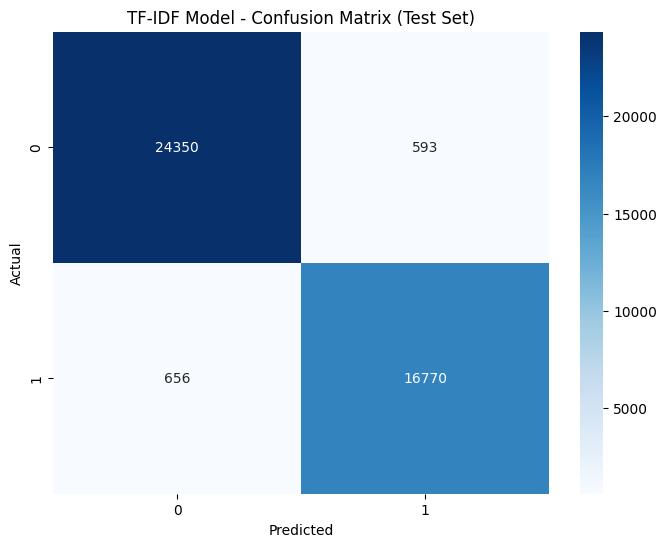

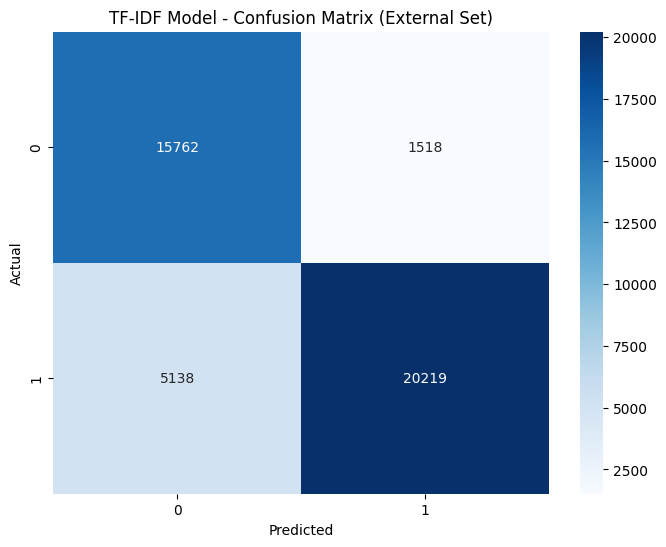

In [45]:
from scipy.sparse import hstack
tfidf = TfidfVectorizer(
    max_features=config["tfidf_max_features"],
    ngram_range=config["tfidf_ngram_range"],
    min_df=config["tfidf_min_df"],
    max_df=config["tfidf_max_df"]
)


X_tfidf_train = tfidf.fit_transform(train_df['body_subject'].to_list())
X_tfidf_test = tfidf.transform(test_df['body_subject'].to_list())
X_tfidf_external = tfidf.transform(external_df['body_subject'].to_list())

X_combined_train = hstack([X_tfidf_train, features_train])
X_combined_test = hstack([X_tfidf_test, features_test])
X_combined_external = hstack([X_tfidf_external, features_external])

print(f"Combined feature shape: {X_combined_train.shape}")
print(f"  TF-IDF features: {X_tfidf_train.shape[1]}")
print(f"  Engineered features: {features_train.shape[1]}")

lr_clf = LogisticRegression(
    max_iter=config["lr_max_iter"],
    C=config["lr_C"],
    random_state=config["random_seed"],
    verbose=1
)
lr_clf.fit(X_combined_train, y_train)

# Evaluate on test set
y_pred_test = lr_clf.predict(X_combined_test)
y_proba_test = lr_clf.predict_proba(X_combined_test)[:, 1]
tfidf_test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test),
    'precision': precision_score(y_test, y_pred_test, zero_division=0),
    'recall': recall_score(y_test, y_pred_test, zero_division=0),
    'f1': f1_score(y_test, y_pred_test, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_test)
}

print(f"\nTest Set Metrics:")
for metric, value in tfidf_test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Evaluate on external set
y_pred_ext = lr_clf.predict(X_combined_external)
y_proba_ext = lr_clf.predict_proba(X_combined_external)[:, 1]

tfidf_external_metrics = {
    'accuracy': accuracy_score(y_external, y_pred_ext),
    'precision': precision_score(y_external, y_pred_ext, zero_division=0),
    'recall': recall_score(y_external, y_pred_ext, zero_division=0),
    'f1': f1_score(y_external, y_pred_ext, zero_division=0),
    'roc_auc': roc_auc_score(y_external, y_proba_ext)
}

print(f"\nExternal Set Metrics:")
for metric, value in tfidf_external_metrics.items():
    print(f"  {metric}: {value:.4f}")

feature_names = list(tfidf.vocabulary_.keys()) + numeric_features
coefficients = lr_clf.coef_[0]
feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)

for i, (name, coef) in enumerate(feature_importance[:20], 1):
    print(f"{i:2d}. {name:<30s} {coef:+.6f}")

# Log to WandB
wandb.log({
    "tfidf/test_accuracy": tfidf_test_metrics['accuracy'],
    "tfidf/test_precision": tfidf_test_metrics['precision'],
    "tfidf/test_recall": tfidf_test_metrics['recall'],
    "tfidf/test_f1": tfidf_test_metrics['f1'],
    "tfidf/test_roc_auc": tfidf_test_metrics['roc_auc'],
    "tfidf/external_accuracy": tfidf_external_metrics['accuracy'],
    "tfidf/external_precision": tfidf_external_metrics['precision'],
    "tfidf/external_recall": tfidf_external_metrics['recall'],
    "tfidf/external_f1": tfidf_external_metrics['f1'],
    "tfidf/external_roc_auc": tfidf_external_metrics['roc_auc'],
})

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('TF-IDF Model - Confusion Matrix (Test Set)')
plt.show()
wandb.log({"tfidf/confusion_matrix": wandb.Image(fig)})
plt.close()

cm = confusion_matrix(y_external, y_pred_ext)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('TF-IDF Model - Confusion Matrix (External Set)')
plt.show()
wandb.log({"tfidf/confusion_matrix": wandb.Image(fig)})
plt.close()

## 8. Train Hybrid XGBoost Model

Combined feature shape: (127107, 112)
  SVD embeddings: 100
  Engineered features: 12

Training XGBoost...
[0]	validation_0-logloss:0.60693	validation_0-auc:0.96677	validation_1-logloss:0.60783	validation_1-auc:0.96322
[10]	validation_0-logloss:0.28303	validation_0-auc:0.98838	validation_1-logloss:0.29185	validation_1-auc:0.98436
[20]	validation_0-logloss:0.17633	validation_0-auc:0.99218	validation_1-logloss:0.19079	validation_1-auc:0.98812
[30]	validation_0-logloss:0.12858	validation_0-auc:0.99486	validation_1-logloss:0.14764	validation_1-auc:0.99076
[40]	validation_0-logloss:0.10284	validation_0-auc:0.99645	validation_1-logloss:0.12506	validation_1-auc:0.99250
[50]	validation_0-logloss:0.08690	validation_0-auc:0.99746	validation_1-logloss:0.11210	validation_1-auc:0.99361
[60]	validation_0-logloss:0.07429	validation_0-auc:0.99823	validation_1-logloss:0.10217	validation_1-auc:0.99449
[70]	validation_0-logloss:0.06408	validation_0-auc:0.99880	validation_1-logloss:0.09428	validation_1-au

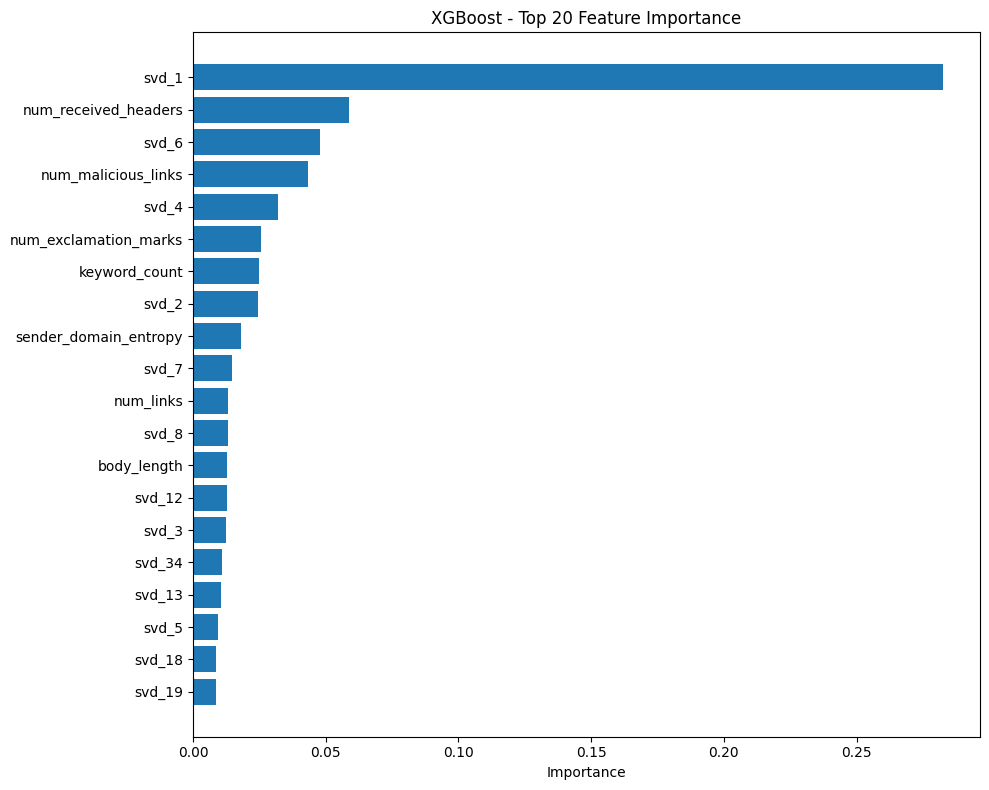

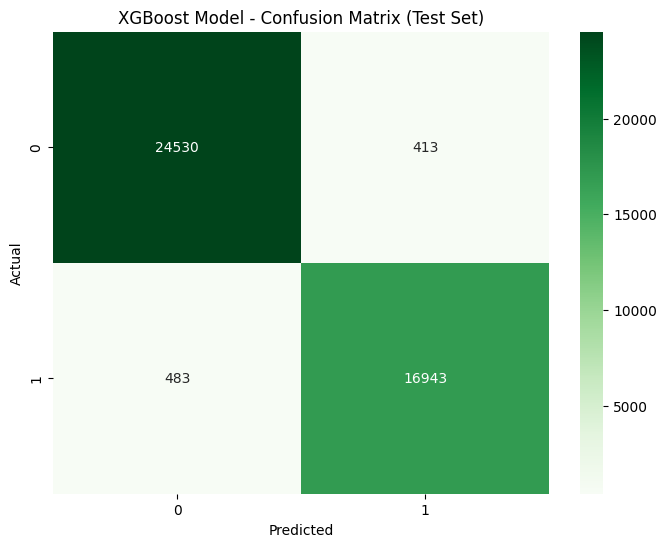

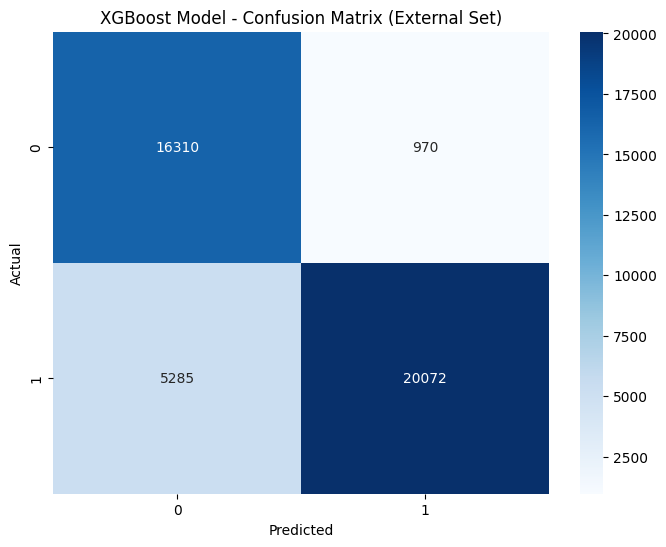

In [ ]:
X_xgb_train = np.concatenate([X_emb_train, features_train], axis=1)
X_xgb_test = np.concatenate([X_emb_test, features_test], axis=1)
X_xgb_external = np.concatenate([X_emb_external, features_external], axis=1)

print(f"Combined feature shape: {X_xgb_train.shape}")
print(f"  Full embeddings: {X_emb_train.shape[1]}")
print(f"  Engineered features: {features_train.shape[1]}")

# Train XGBoost with WandB callback
xgb_clf = xgb.XGBClassifier(
    max_depth=config["xgb_max_depth"],
    n_estimators=config["xgb_n_estimators"],
    learning_rate=config["xgb_learning_rate"],
    min_child_weight=config["xgb_min_child_weight"],
    subsample=config["xgb_subsample"],
    colsample_bytree=config["xgb_colsample_bytree"],
    random_state=config["random_seed"],
    eval_metric=["logloss", "auc"],
    early_stopping_rounds=config["xgb_early_stopping"],
    callbacks=[wandb.xgboost.WandbCallback(log_model=True)]
)

print("\nTraining XGBoost...")
xgb_clf.fit(
    X_xgb_train, y_train,
    eval_set=[(X_xgb_train, y_train), (X_xgb_test, y_test)],
    verbose=10
)

# Evaluate on test set
y_pred_test = xgb_clf.predict(X_xgb_test)
y_proba_test = xgb_clf.predict_proba(X_xgb_test)[:, 1]

xgb_test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test),
    'precision': precision_score(y_test, y_pred_test, zero_division=0),
    'recall': recall_score(y_test, y_pred_test, zero_division=0),
    'f1': f1_score(y_test, y_pred_test, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_test)
}

print(f"\nTest Set Metrics:")
for metric, value in xgb_test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Evaluate on external set
y_pred_ext = xgb_clf.predict(X_xgb_external)
y_proba_ext = xgb_clf.predict_proba(X_xgb_external)[:, 1]

xgb_external_metrics = {
    'accuracy': accuracy_score(y_external, y_pred_ext),
    'precision': precision_score(y_external, y_pred_ext, zero_division=0),
    'recall': recall_score(y_external, y_pred_ext, zero_division=0),
    'f1': f1_score(y_external, y_pred_ext, zero_division=0),
    'roc_auc': roc_auc_score(y_external, y_proba_ext)
}

print(f"\nExternal Set Metrics:")
for metric, value in xgb_external_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Log to WandB
wandb.log({
    "xgboost/test_accuracy": xgb_test_metrics['accuracy'],
    "xgboost/test_precision": xgb_test_metrics['precision'],
    "xgboost/test_recall": xgb_test_metrics['recall'],
    "xgboost/test_f1": xgb_test_metrics['f1'],
    "xgboost/test_roc_auc": xgb_test_metrics['roc_auc'],
    "xgboost/external_accuracy": xgb_external_metrics['accuracy'],
    "xgboost/external_precision": xgb_external_metrics['precision'],
    "xgboost/external_recall": xgb_external_metrics['recall'],
    "xgboost/external_f1": xgb_external_metrics['f1'],
    "xgboost/external_roc_auc": xgb_external_metrics['roc_auc'],
})

feature_names = [f"emb_{i}" for i in range(X_emb_train.shape[1])] + numeric_features
importance = xgb_clf.feature_importances_
feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

print("\nTop 20 Important Features:")
for i, (name, imp) in enumerate(feature_importance[:20], 1):
    print(f"{i:2d}. {name:<30s} {imp:.6f}")

fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance[:20]
ax.barh([f[0] for f in top_features][::-1], [f[1] for f in top_features][::-1])
ax.set_xlabel('Importance')
ax.set_title('XGBoost - Top 20 Feature Importance')
plt.tight_layout()
wandb.log({"xgboost/feature_importance": wandb.Image(fig)})
plt.show()
plt.close()

# Confusion matrix for XGBoost
cm = confusion_matrix(y_test, y_pred_test)
fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax_cm)
ax_cm.set_xlabel('Predicted')
ax_cm.set_ylabel('Actual')
ax_cm.set_title('XGBoost Model - Confusion Matrix (Test Set)')
wandb.log({"xgboost/confusion_matrix": wandb.Image(fig_cm)})
plt.show()
plt.close()

cm = confusion_matrix(y_external, y_pred_ext)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('XGBoost Model - Confusion Matrix (External Set)')
plt.show()
wandb.log({"xgboost/confusion_matrix": wandb.Image(fig)})
plt.close()

## 9. Train Hybrid MLP Model

In [ ]:
from app.models.hybrid_mlp_model import HybridMLPClassifier

X_emb_train_fit, X_emb_val, X_feat_train_fit, X_feat_val, y_train_fit, y_val = train_test_split(
    X_emb_train, features_train, y_train, 
    test_size=0.2, 
    random_state=config["random_seed"], 
    stratify=y_train
)

print(f"Train: {X_emb_train_fit.shape[0]} | Val: {X_emb_val.shape[0]} | Test: {X_emb_test.shape[0]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = HybridMLPClassifier(
    embedding_dim=config["embedding_dim"],
    num_features=len(numeric_features),
    feature_hidden_dim=config["mlp_feature_hidden_dim"],
    dropout=config["mlp_dropout"]
).to(device)

print(mlp_model)
print(f"\nTotal parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")

# Create data loaders
train_dataset = TensorDataset(
    torch.FloatTensor(X_emb_train_fit),
    torch.FloatTensor(X_feat_train_fit),
    torch.FloatTensor(y_train_fit)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_emb_val),
    torch.FloatTensor(X_feat_val),
    torch.FloatTensor(y_val)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_emb_test),
    torch.FloatTensor(features_test),
    torch.FloatTensor(y_test)
)

train_loader = DataLoader(train_dataset, batch_size=config["mlp_batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["mlp_batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

# Training setup
optimizer = torch.optim.Adam(
    mlp_model.parameters(), 
    lr=config["mlp_lr"], 
    weight_decay=config["mlp_weight_decay"]
)
criterion = nn.BCEWithLogitsLoss()

# Training loop
best_val_loss = float('inf')
patience_counter = 0

print("\nTraining MLP...")
for epoch in range(config["mlp_epochs"]):
    # Training
    mlp_model.train()
    train_loss = 0
    for embeddings, features, labels in train_loader:
        embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = mlp_model(embeddings, features).squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    mlp_model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for embeddings, features, labels in val_loader:
            embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
            
            logits = mlp_model(embeddings, features).squeeze()
            loss = criterion(logits, labels)
            val_loss += loss.item()
            
            probs = torch.sigmoid(logits)
            val_preds.extend(probs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    val_pred_binary = (val_preds > 0.5).astype(int)
    
    val_acc = accuracy_score(val_labels, val_pred_binary)
    val_f1 = f1_score(val_labels, val_pred_binary, zero_division=0)
    
    # Log to WandB
    wandb.log({
        "mlp/epoch": epoch,
        "mlp/train_loss": train_loss,
        "mlp/val_loss": val_loss,
        "mlp/val_accuracy": val_acc,
        "mlp/val_f1": val_f1
    })
    
    print(f"Epoch {epoch+1}/{config['mlp_epochs']}: "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        best_model_state = mlp_model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= config["mlp_early_stopping"]:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
mlp_model.load_state_dict(best_model_state)

Train: 101685 | Val: 25422 | Test: 42369
HybridMLPClassifier(
  (feature_branch): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=416, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Total parameters: 140,193

Training MLP...
Epoch 1/50: Train Loss: 0.1511 | Val Loss: 0.0917 | Val Acc: 0.9670 | Val F1: 0.9594
Epoch 2/50: Train Loss: 0.0868 | Val Loss: 0.0738 | Val Acc: 0.9734 | Val F1: 0.9676
Epoch 3/50: Train Loss: 0.0719 | Val Loss: 0.0645 | Val Acc: 0.9778 | Val F1: 0.9731
Epoch 4/50: Train Loss: 0.0620 | Val Loss: 0.0634 | Val Acc: 0.9776 | Val F1: 0.9729
Epoch 5/50: Train Loss: 0.0563 | Val Loss: 0.0607 | Val Acc: 0.9782 | Val F

<All keys matched successfully>


MLP Test Set Metrics:
  accuracy: 0.9808
  precision: 0.9836
  recall: 0.9694
  f1: 0.9764
  roc_auc: 0.9978

MLP External Set Metrics:
  accuracy: 0.8569
  precision: 0.9632
  recall: 0.7896
  f1: 0.8678
  roc_auc: 0.9264

MLP External Set Metrics:
  accuracy: 0.8569
  precision: 0.9632
  recall: 0.7896
  f1: 0.8678
  roc_auc: 0.9264


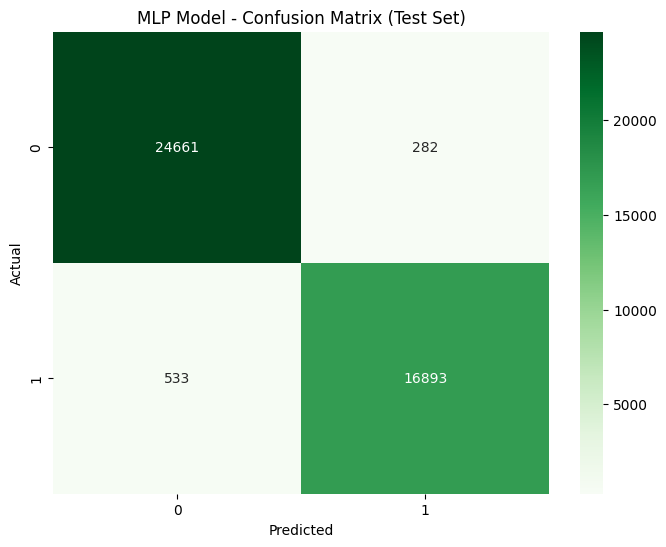

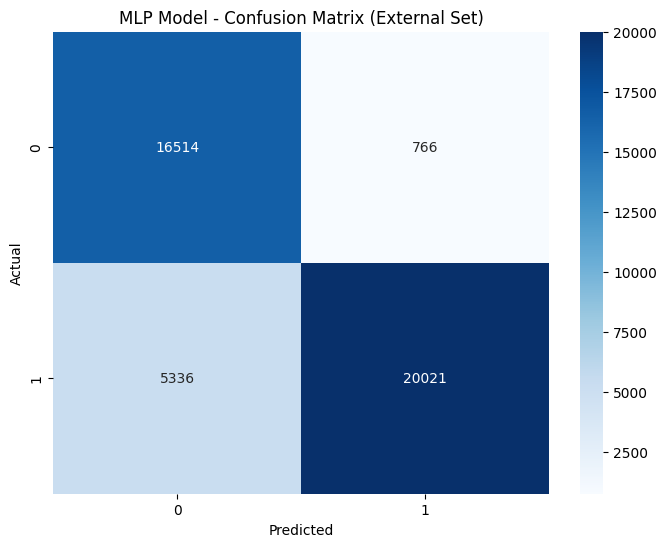

In [49]:
# Evaluate MLP on test set
mlp_model.eval()
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for embeddings, features, labels in test_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        # Handle both batch and single samples
        if probs.dim() == 0:
            test_probs.append(probs.cpu().item())
            test_labels.append(labels.item())
        else:
            test_probs.extend(probs.cpu().numpy())
            test_labels.extend(labels.numpy())

test_probs = np.array(test_probs)
test_labels = np.array(test_labels)
test_preds = (test_probs > 0.5).astype(int)

mlp_test_metrics = {
    'accuracy': accuracy_score(test_labels, test_preds),
    'precision': precision_score(test_labels, test_preds, zero_division=0),
    'recall': recall_score(test_labels, test_preds, zero_division=0),
    'f1': f1_score(test_labels, test_preds, zero_division=0),
    'roc_auc': roc_auc_score(test_labels, test_probs)
}

print(f"\nMLP Test Set Metrics:")
for metric, value in mlp_test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Evaluate on external set
external_dataset = TensorDataset(
    torch.FloatTensor(X_emb_external),
    torch.FloatTensor(features_external),
    torch.FloatTensor(y_external)
)
external_loader = DataLoader(external_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

ext_preds = []
ext_labels = []
ext_probs = []

with torch.no_grad():
    for embeddings, features, labels in external_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        # Handle both batch and single samples
        if probs.dim() == 0:
            ext_probs.append(probs.cpu().item())
            ext_labels.append(labels.item())
        else:
            ext_probs.extend(probs.cpu().numpy())
            ext_labels.extend(labels.numpy())

ext_probs = np.array(ext_probs)
ext_labels = np.array(ext_labels)
ext_preds = (ext_probs > 0.5).astype(int)

mlp_external_metrics = {
    'accuracy': accuracy_score(ext_labels, ext_preds),
    'precision': precision_score(ext_labels, ext_preds, zero_division=0),
    'recall': recall_score(ext_labels, ext_preds, zero_division=0),
    'f1': f1_score(ext_labels, ext_preds, zero_division=0),
    'roc_auc': roc_auc_score(ext_labels, ext_probs)
}

print(f"\nMLP External Set Metrics:")
for metric, value in mlp_external_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Log to WandB
wandb.log({
    "mlp/test_accuracy": mlp_test_metrics['accuracy'],
    "mlp/test_precision": mlp_test_metrics['precision'],
    "mlp/test_recall": mlp_test_metrics['recall'],
    "mlp/test_f1": mlp_test_metrics['f1'],
    "mlp/test_roc_auc": mlp_test_metrics['roc_auc'],
    "mlp/external_accuracy": mlp_external_metrics['accuracy'],
    "mlp/external_precision": mlp_external_metrics['precision'],
    "mlp/external_recall": mlp_external_metrics['recall'],
    "mlp/external_f1": mlp_external_metrics['f1'],
    "mlp/external_roc_auc": mlp_external_metrics['roc_auc'],
})

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('MLP Model - Confusion Matrix (Test Set)')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()

cm = confusion_matrix(ext_labels, ext_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('MLP Model - Confusion Matrix (External Set)')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()
plt.close()

## 10. Compare Model Performance

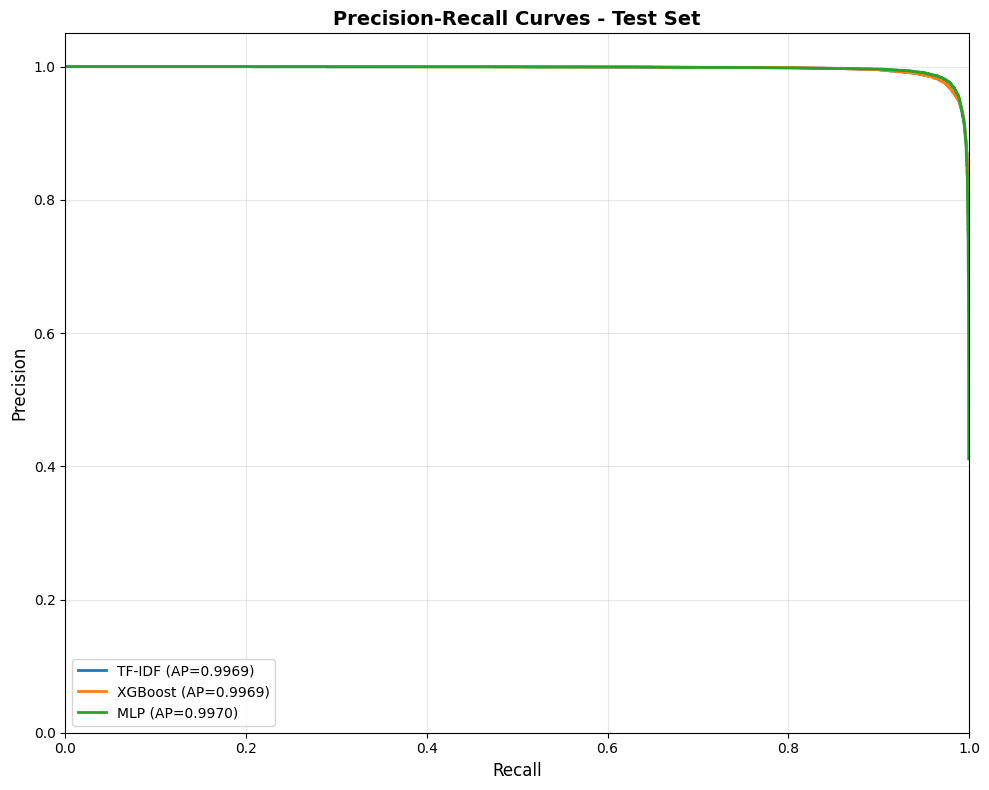


TEST SET PERFORMANCE:
Model                Accuracy     Precision    Recall       F1           ROC-AUC     
--------------------------------------------------------------------------------
TF-IDF + LogReg      0.9705       0.9658       0.9624       0.9641       0.9953      
XGBoost Hybrid       0.9789       0.9762       0.9723       0.9742       0.9978      
MLP Hybrid           0.9808       0.9836       0.9694       0.9764       0.9978      

EXTERNAL VALIDATION SET PERFORMANCE:
Model                Accuracy     Precision    Recall       F1           ROC-AUC     
--------------------------------------------------------------------------------
TF-IDF + LogReg      0.8439       0.9302       0.7974       0.8587       0.8595      
XGBoost Hybrid       0.8533       0.9539       0.7916       0.8652       0.9050      
MLP Hybrid           0.8569       0.9632       0.7896       0.8678       0.9264      


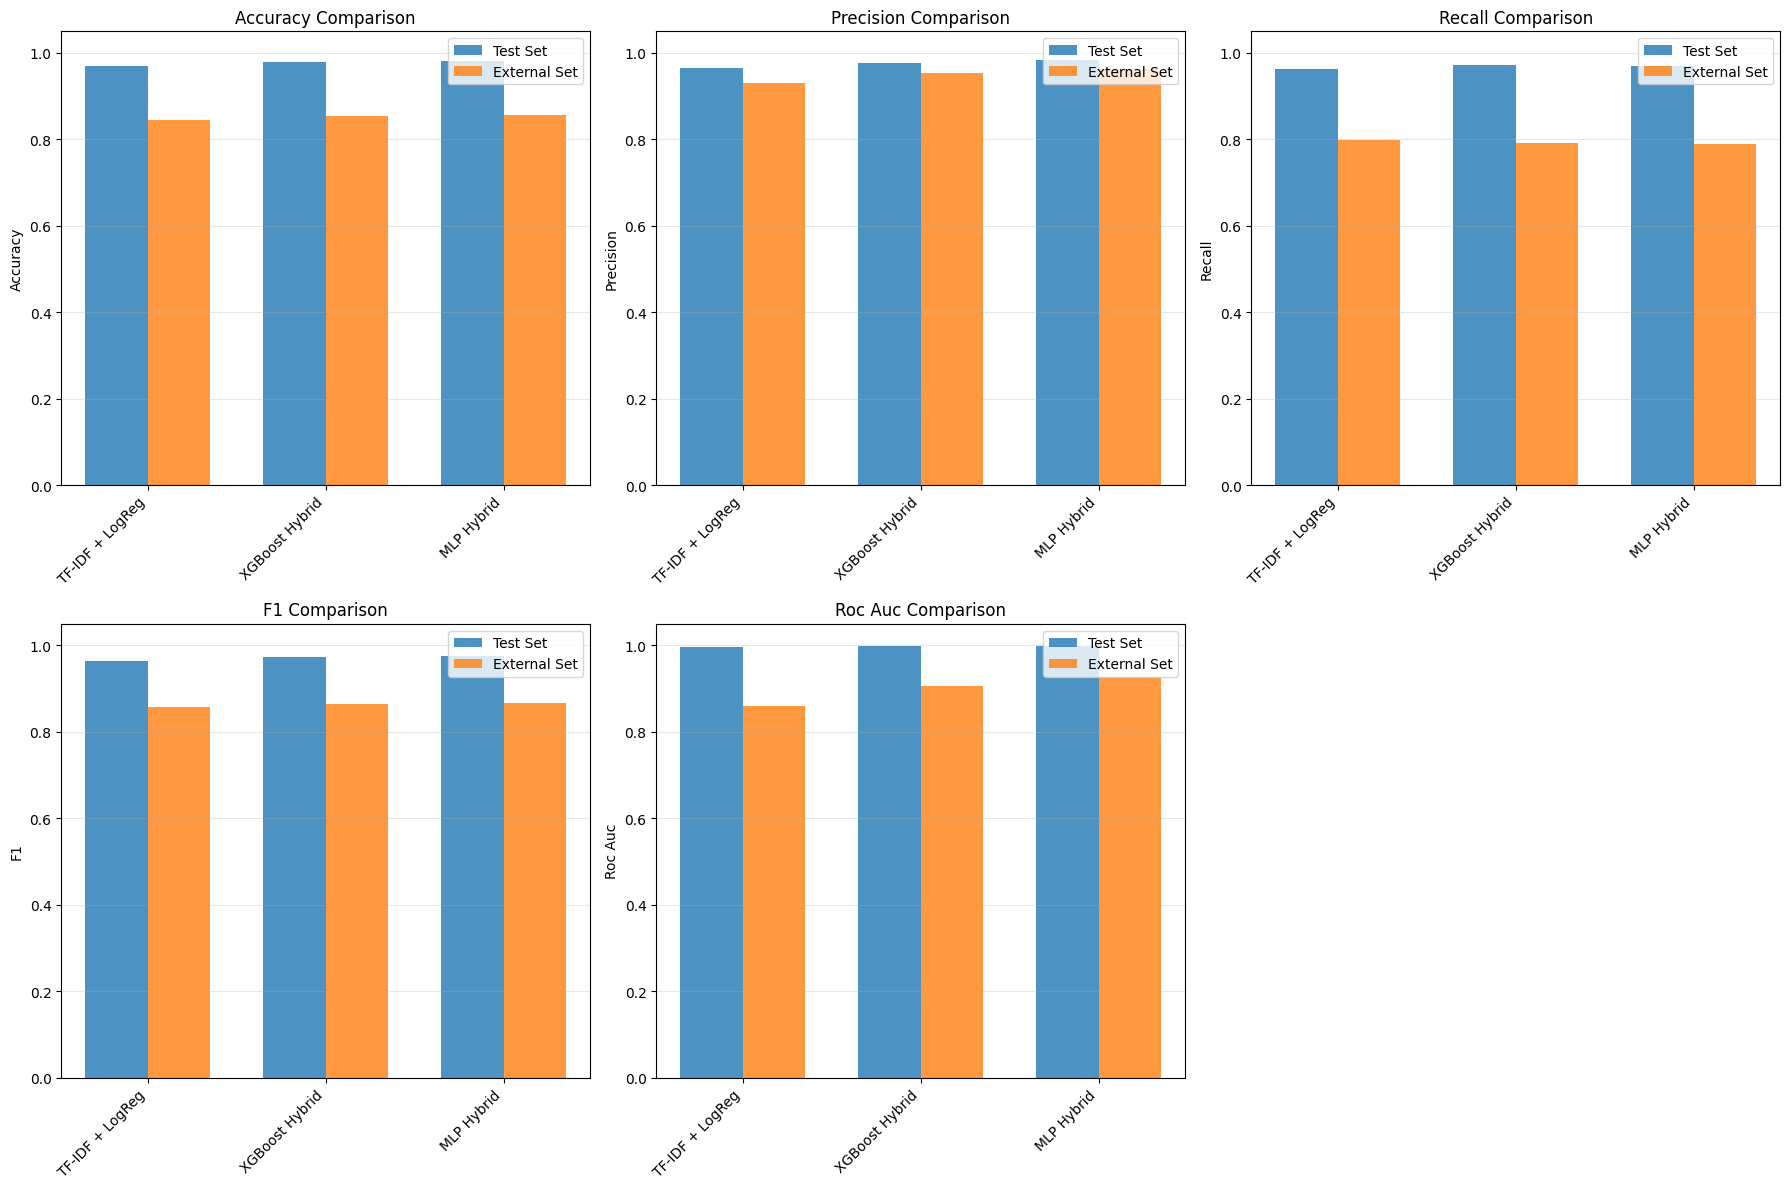

In [50]:
# Create comprehensive comparison
comparison_data = {
    'TF-IDF + LogReg': {
        'test': tfidf_test_metrics,
        'external': tfidf_external_metrics
    },
    'XGBoost Hybrid': {
        'test': xgb_test_metrics,
        'external': xgb_external_metrics
    },
    'MLP Hybrid': {
        'test': mlp_test_metrics,
        'external': mlp_external_metrics
    }
}

from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate PR curves
tfidf_precision_test, tfidf_recall_test, _ = precision_recall_curve(y_test, y_proba_test)
xgb_precision_test, xgb_recall_test, _ = precision_recall_curve(y_test, xgb_clf.predict_proba(X_xgb_test)[:, 1])
mlp_precision_test, mlp_recall_test, _ = precision_recall_curve(test_labels, test_probs)

# Calculate average precision
tfidf_ap = average_precision_score(y_test, y_proba_test)
xgb_ap = average_precision_score(y_test, xgb_clf.predict_proba(X_xgb_test)[:, 1])
mlp_ap = average_precision_score(test_labels, test_probs)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tfidf_recall_test, tfidf_precision_test, label=f'TF-IDF (AP={tfidf_ap:.4f})', linewidth=2)
ax.plot(xgb_recall_test, xgb_precision_test, label=f'XGBoost (AP={xgb_ap:.4f})', linewidth=2)
ax.plot(mlp_recall_test, mlp_precision_test, label=f'MLP (AP={mlp_ap:.4f})', linewidth=2)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - Test Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
wandb.log({"comparison/pr_curves": wandb.Image(fig)})
plt.show()
plt.close()

# Test set comparison
print("\nTEST SET PERFORMANCE:")
print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'ROC-AUC':<12}")
print("-" * 80)
for model_name, metrics in comparison_data.items():
    test_m = metrics['test']
    print(f"{model_name:<20} {test_m['accuracy']:<12.4f} {test_m['precision']:<12.4f} "
          f"{test_m['recall']:<12.4f} {test_m['f1']:<12.4f} {test_m['roc_auc']:<12.4f}")

# External set comparison
print("\nEXTERNAL VALIDATION SET PERFORMANCE:")
print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'ROC-AUC':<12}")
print("-" * 80)
for model_name, metrics in comparison_data.items():
    ext_m = metrics['external']
    print(f"{model_name:<20} {ext_m['accuracy']:<12.4f} {ext_m['precision']:<12.4f} "
          f"{ext_m['recall']:<12.4f} {ext_m['f1']:<12.4f} {ext_m['roc_auc']:<12.4f}")

# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    models = list(comparison_data.keys())
    test_values = [comparison_data[m]['test'][metric] for m in models]
    external_values = [comparison_data[m]['external'][metric] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    ax.bar(x - width/2, test_values, width, label='Test Set', alpha=0.8)
    ax.bar(x + width/2, external_values, width, label='External Set', alpha=0.8)
    
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
wandb.log({"comparison/metrics_comparison": wandb.Image(fig)})
plt.show()

comparison_table_data = []
for model_name, metrics in comparison_data.items():
    for split, split_metrics in metrics.items():
        row = [model_name, split] + [split_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
        comparison_table_data.append(row)

comparison_table = wandb.Table(
    columns=['Model', 'Split', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'],
    data=comparison_table_data
)
wandb.log({"comparison/performance_table": comparison_table})


## 11. Save Models and Artifacts


In [ ]:
# Create directories
os.makedirs("saved_models", exist_ok=True)
os.makedirs("saved_artifacts", exist_ok=True)

print("Saving models and artifacts...")

with open('saved_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('saved_models/tfidf_classifier.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)
print("✓ TF-IDF model saved")

xgb_clf.save_model('saved_models/xgboost_hybrid.json')
print("✓ XGBoost model saved")

torch.save({
    'model_state_dict': mlp_model.state_dict(),
    'embedding_dim': config["embedding_dim"],
    'num_features': len(numeric_features),
    'feature_hidden_dim': config["mlp_feature_hidden_dim"],
    'dropout': config["mlp_dropout"],
    'test_metrics': mlp_test_metrics,
    'external_metrics': mlp_external_metrics
}, 'saved_models/mlp_hybrid.pth')
print("✓ MLP model saved")

# Save experiment configuration (no SVD)
full_config = {
    'experiment_config': config,
    'data_splits': {
        'train_size': len(train_df),
        'test_size': len(test_df),
        'external_size': len(external_df)
    },
    'model_performance': {
        'tfidf': {
            'test': {k: float(v) for k, v in tfidf_test_metrics.items()},
            'external': {k: float(v) for k, v in tfidf_external_metrics.items()}
        },
        'xgboost': {
            'test': {k: float(v) for k, v in xgb_test_metrics.items()},
            'external': {k: float(v) for k, v in xgb_external_metrics.items()}
        },
        'mlp': {
            'test': {k: float(v) for k, v in mlp_test_metrics.items()},
            'external': {k: float(v) for k, v in mlp_external_metrics.items()}
        }
    },
    'feature_names': numeric_features,
    'timestamp': datetime.now().isoformat()
}

with open('saved_artifacts/experiment_config.json', 'w') as f:
    json.dump(full_config, f, indent=2)
print("✓ Configuration saved")

# Upload artifacts to WandB
artifact = wandb.Artifact('phishstop-models', type='model')
artifact.add_dir('saved_models')
artifact.add_file('saved_artifacts/experiment_config.json')
wandb.log_artifact(artifact)
print("✓ Artifacts uploaded to WandB")



In [ ]:
# Finish WandB run
wandb.finish()
print("✓ WandB run completed")